### Evalute Learned Face Embedding

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\noiba\anaconda3\envs\test\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'title', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
embedding_name = "tracks_16_1000_small_1_rms"
MIN_TRACKS_FOR_IDENTITY = 2

In [25]:
from os import path
episode_name = "friends"
suffix = "mp4"

network_episode_name = episode_name

parent_directory = "."
data_directory = path.join(parent_directory, "data_friends")
network_episode_data_directory = path.join(parent_directory, "data_friends")
output_directory = path.join(data_directory, "output")

In [26]:
tracks_object_path = f"{data_directory}/tracks.{episode_name}.data"
embedded_tracks_path = f"{output_directory}/{embedding_name}.embeded.data"

This enables evaluating embedding from a network that was trained on a different episode.

In [27]:
import pickle 

In [28]:
from evaluate_training import create_tracks_embedding

if network_episode_name != episode_name:
    embedded_new_tracks_path = f"{output_directory}/{embedding_name}.embeded.data"
    create_tracks_embedding(tracks_object_path, "deep", checkpoint_path, 5, embedded_new_tracks_path)

    network_tracks_object_path = f"{network_episode_data_directory}/tracks.{network_episode}.data"
    with open(network_tracks_object_path, 'rb') as file:
        network_tracks_data = pickle.load(file)

In [29]:
import pickle 
from collections import Counter

with open(tracks_object_path, 'rb') as file:
    tracks_data = pickle.load(file)
    if network_episode_name == episode_name:
        network_label_occurences = Counter(tracks_data.labels.values())
    else:
        network_label_occurences = Counter(network_tracks_data.labels.values())
with open(embedded_tracks_path, 'rb') as file:
    tracks_embedded_data = pickle.load(file)

In [30]:
FALSE_ALARM_LABEL = "false_alarm"
ORIGINAL_FEATURE_SHAPE = 2048

def filter_track_ids(track_ids, labels):
    track_ids = [track for track in track_ids if network_label_occurences[labels[track]] > MIN_TRACKS_FOR_IDENTITY
            and labels[track].lower() != FALSE_ALARM_LABEL]
    return track_ids

# Cluster tracks ids that belong to main characters in the network's episode.
track_ids = list(tracks_data.tracks.keys())
track_ids = filter_track_ids(track_ids, tracks_data.labels)
NUM_CLUSTERS = len(Counter([tracks_data.labels[t] for t in track_ids]).keys())
print(f'{NUM_CLUSTERS} clusters')

# Read tracks images and tracks features for visualizing the embedding and cluster the tracks
# by the original and new embedded features.
original_track_features = list(tracks_data.get_tracks_representations(track_ids).values())
embedding_size = len(tracks_embedded_data[track_ids[0]])
embedded_track_features = np.empty(shape=(len(track_ids), embedding_size))
tracks_images = []
labels = []

track_index = 0
for track in track_ids:
    labels.append(tracks_data.labels[track])
    embedded_track_features[track_index] = tracks_embedded_data[track]
    track_index += 1
    time = list(tracks_data.tracks[track].keys())[0]
    tracks_images.append(tracks_data.img[(track, time)])

3 clusters


In [31]:
from clustering_scores import get_clusters_scores, plot_clusters, scatter_thumbnails, get_labels_dict

In [32]:
def plot_thumbnails(features, images, title, subtitle):
    _ = scatter_thumbnails(features, images)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path.join(output_directory, f'{title} {subtitle}.png'))
    plt.show()

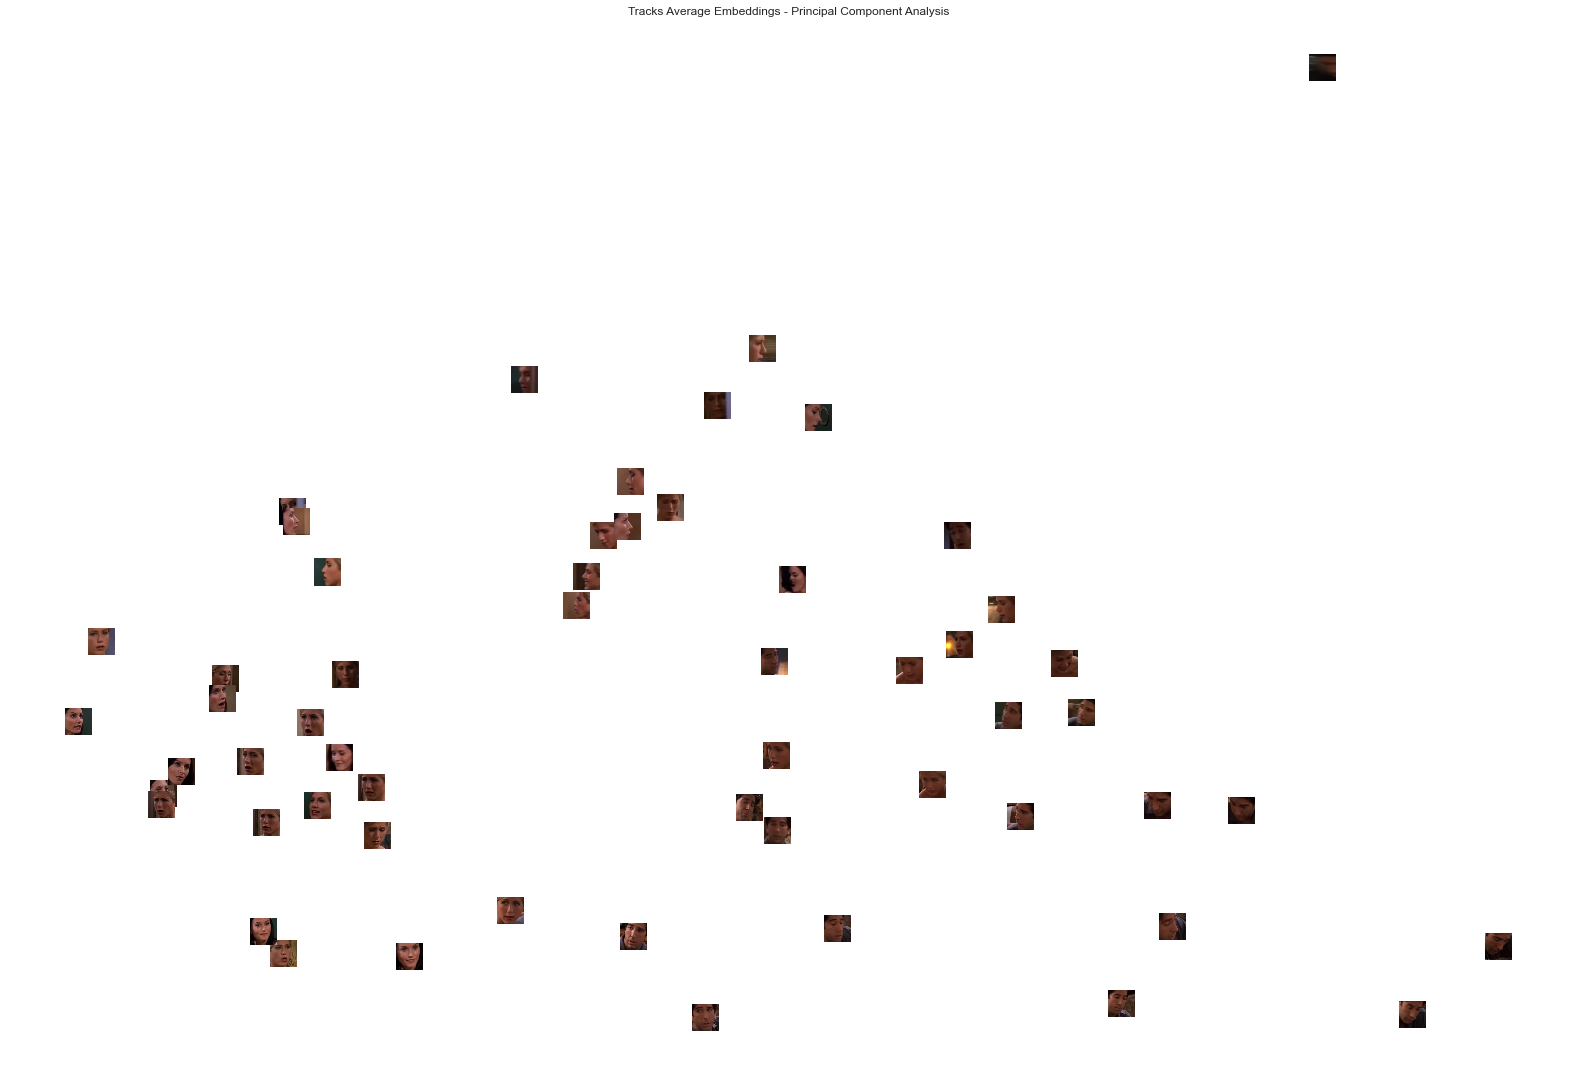

In [33]:
title = 'Tracks Average Embeddings - Principal Component Analysis'
subtitle = embedding_name
plot_thumbnails(original_track_features, tracks_images, title, subtitle)

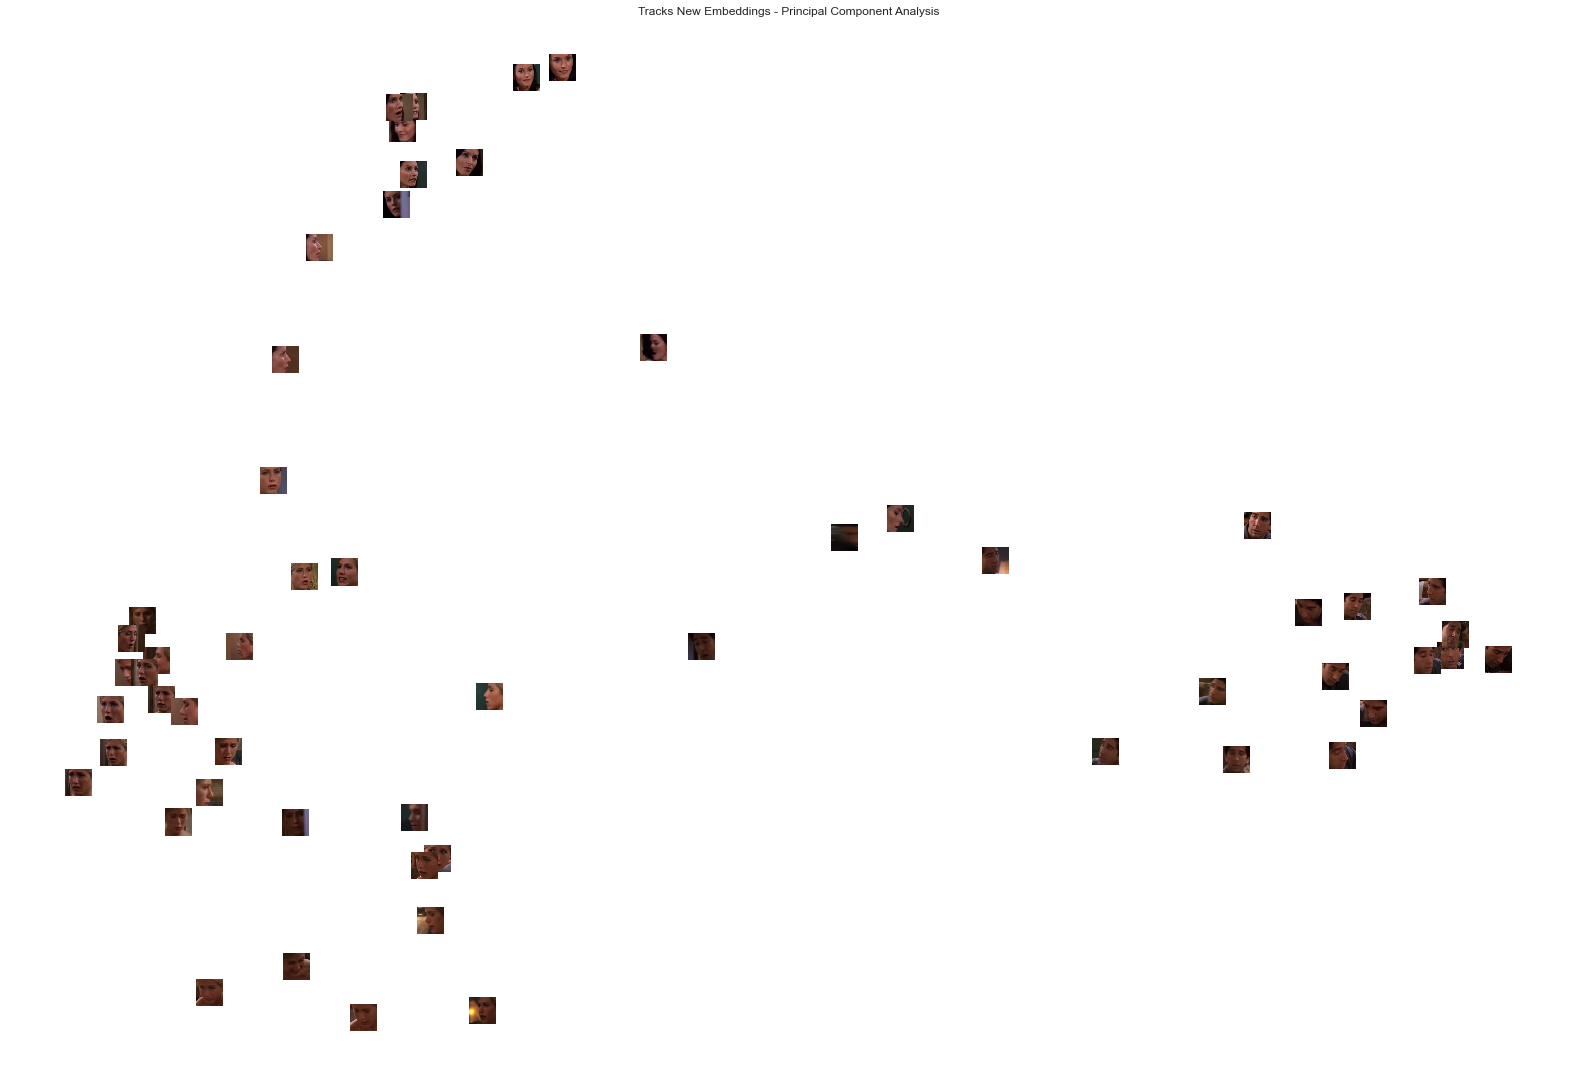

In [34]:
title = 'Tracks New Embeddings - Principal Component Analysis'
subtitle = embedding_name
plot_thumbnails(embedded_track_features, tracks_images, title, subtitle)

In [35]:
import sklearn.cluster as cluster
!pip install -q hdbscan
import hdbscan
import seaborn as sns

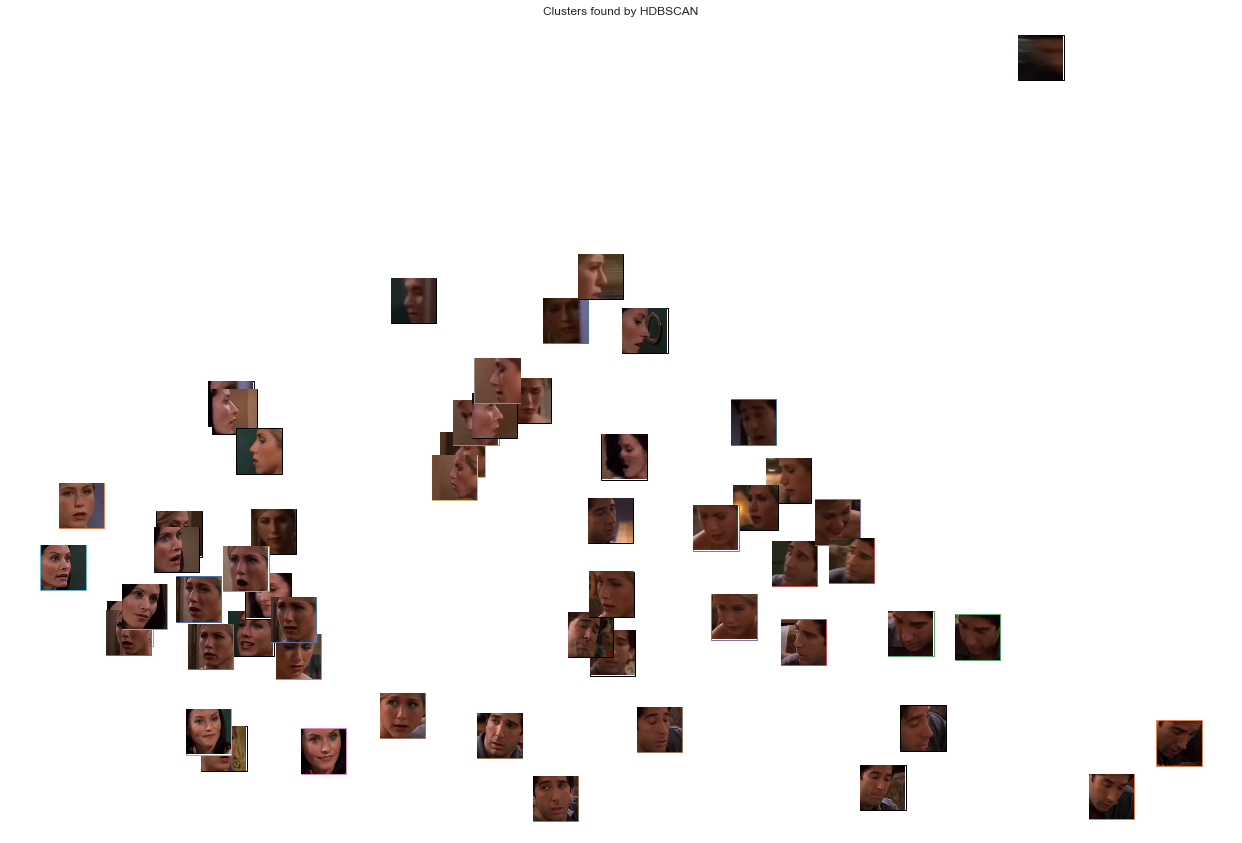

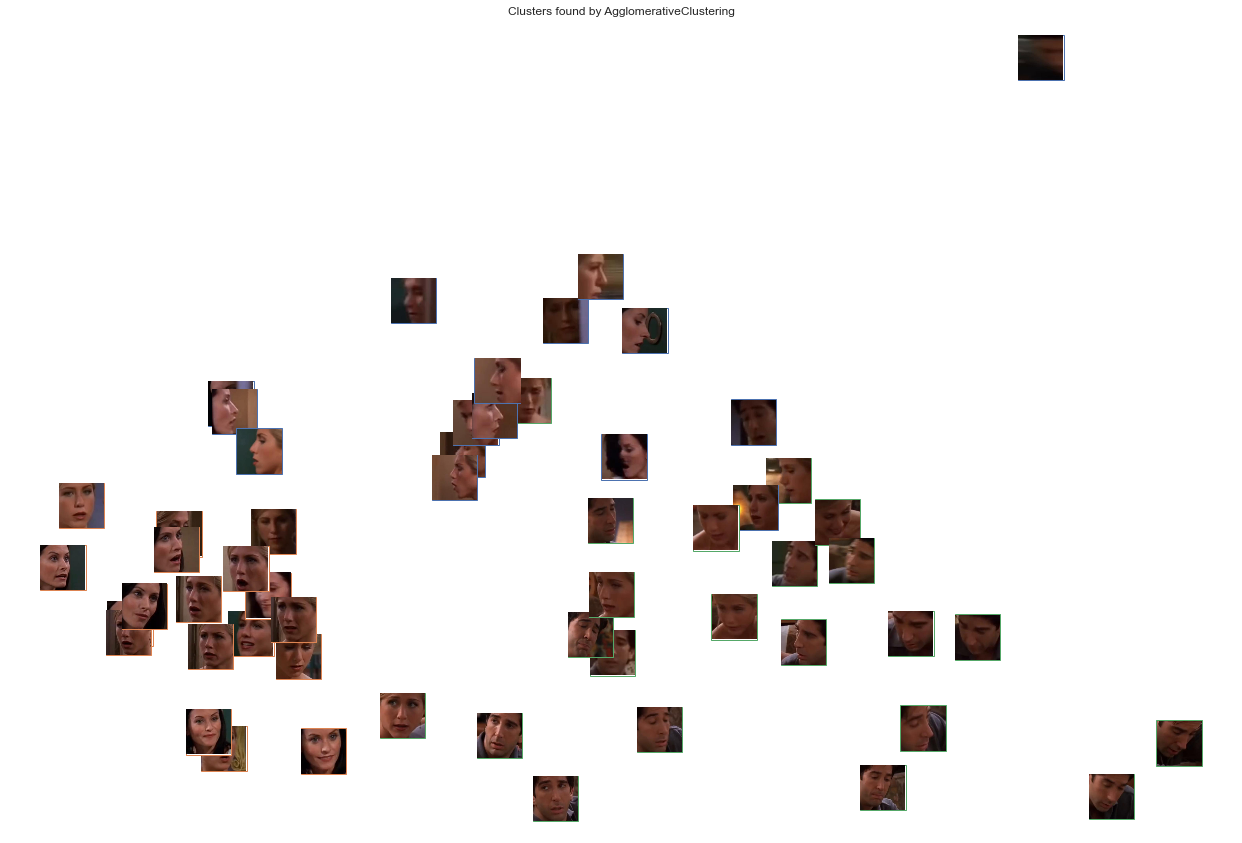

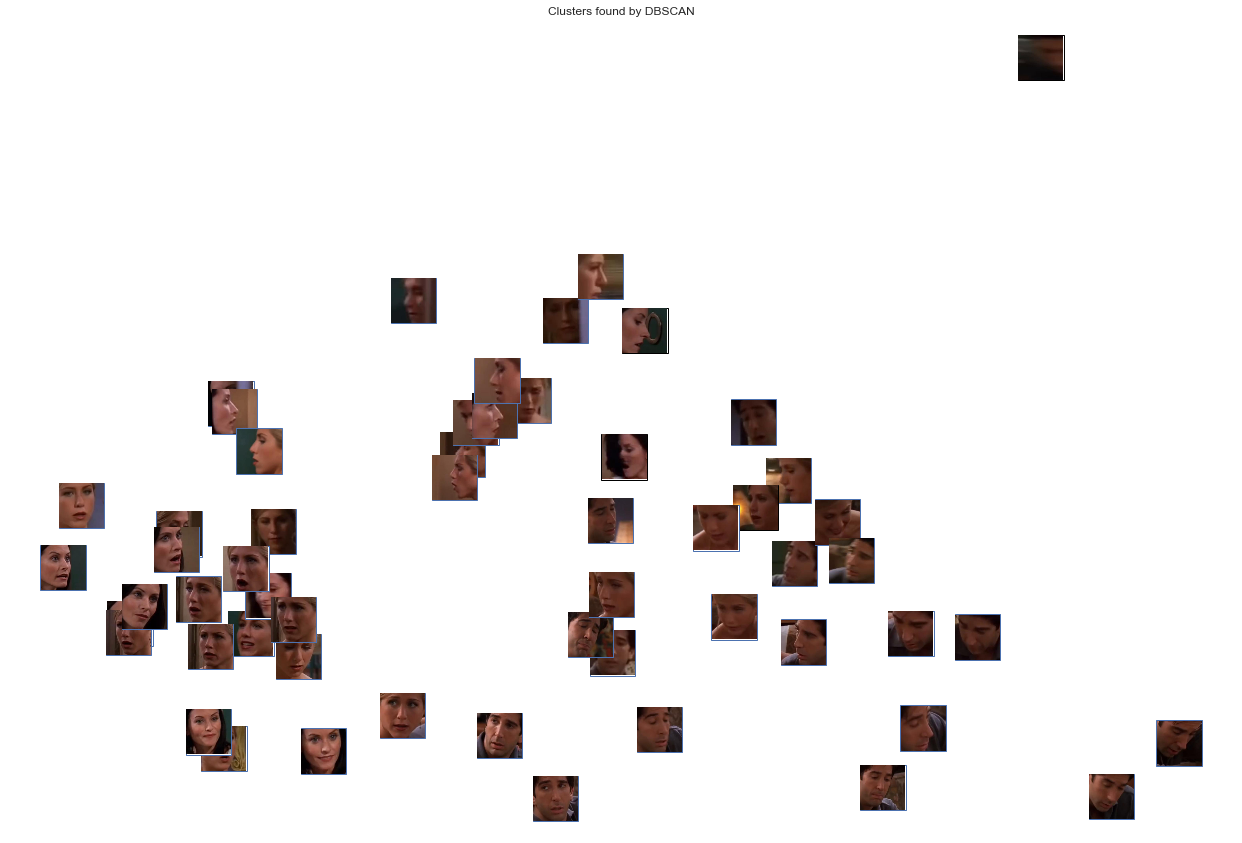

In [36]:
original_clusters_hdbscan = plot_clusters(original_track_features, tracks_images, hdbscan.HDBSCAN, alpha=1.0, min_cluster_size=MIN_TRACKS_FOR_IDENTITY, min_samples=1)
original_clusters_agglomerative = plot_clusters(original_track_features, tracks_images, cluster.AgglomerativeClustering, n_clusters=NUM_CLUSTERS, linkage='ward')
original_clusters_dbscan = plot_clusters(original_track_features, tracks_images, cluster.DBSCAN, n_jobs=-1, eps=0.5, min_samples=MIN_TRACKS_FOR_IDENTITY)

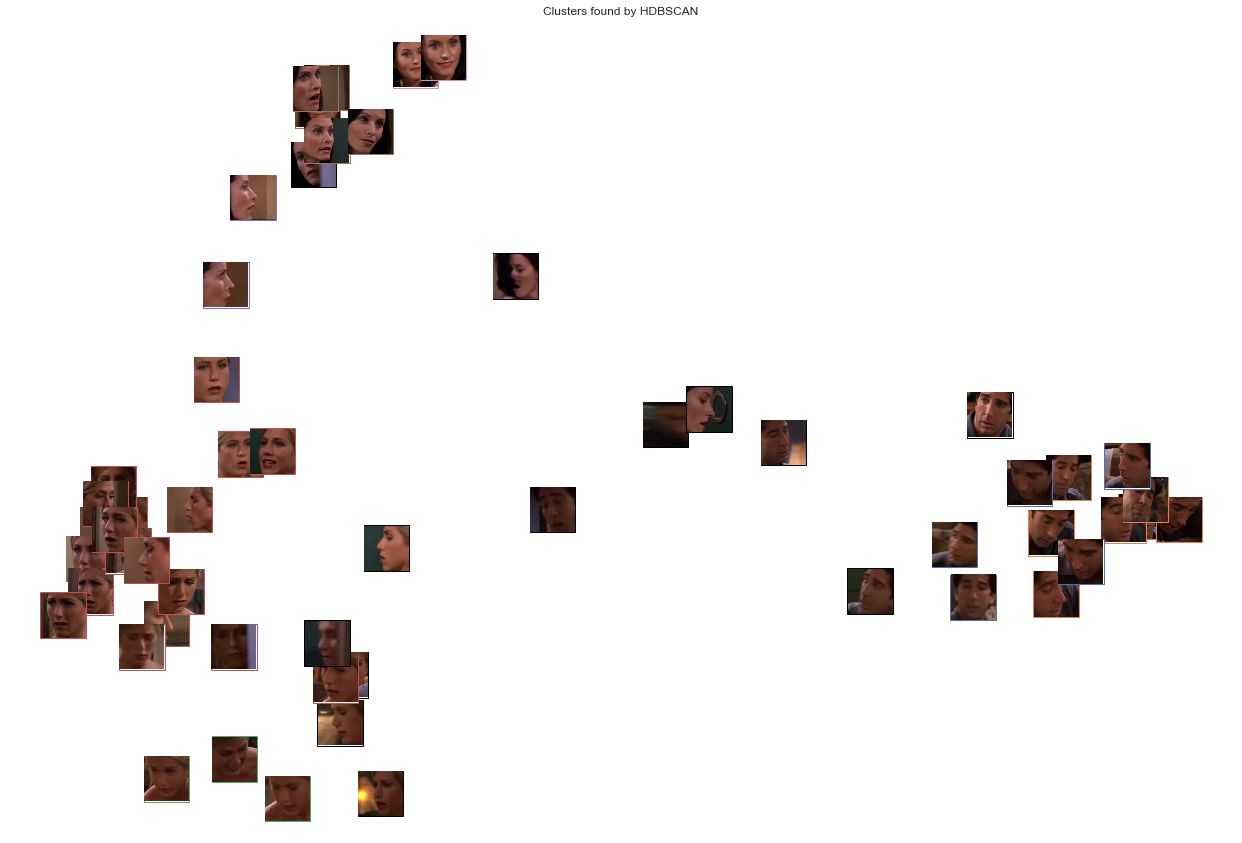

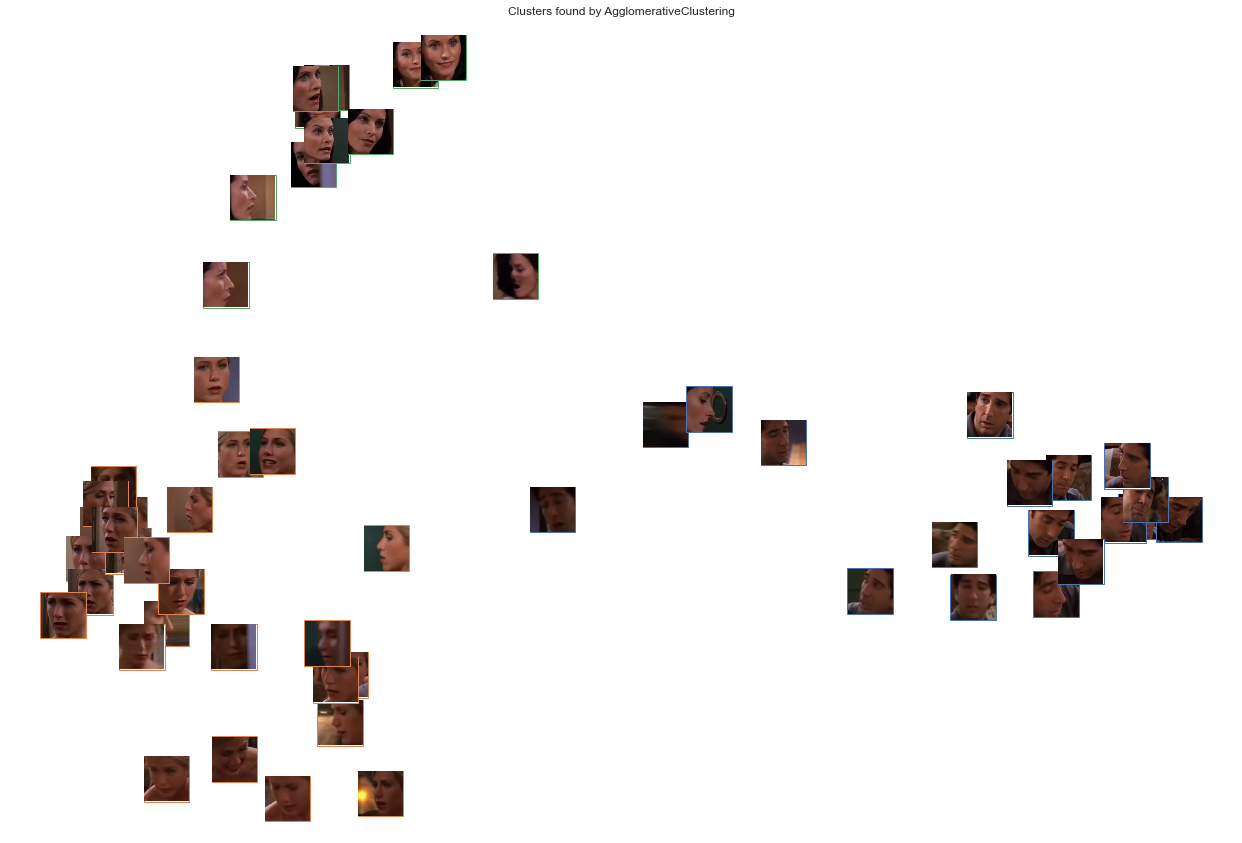

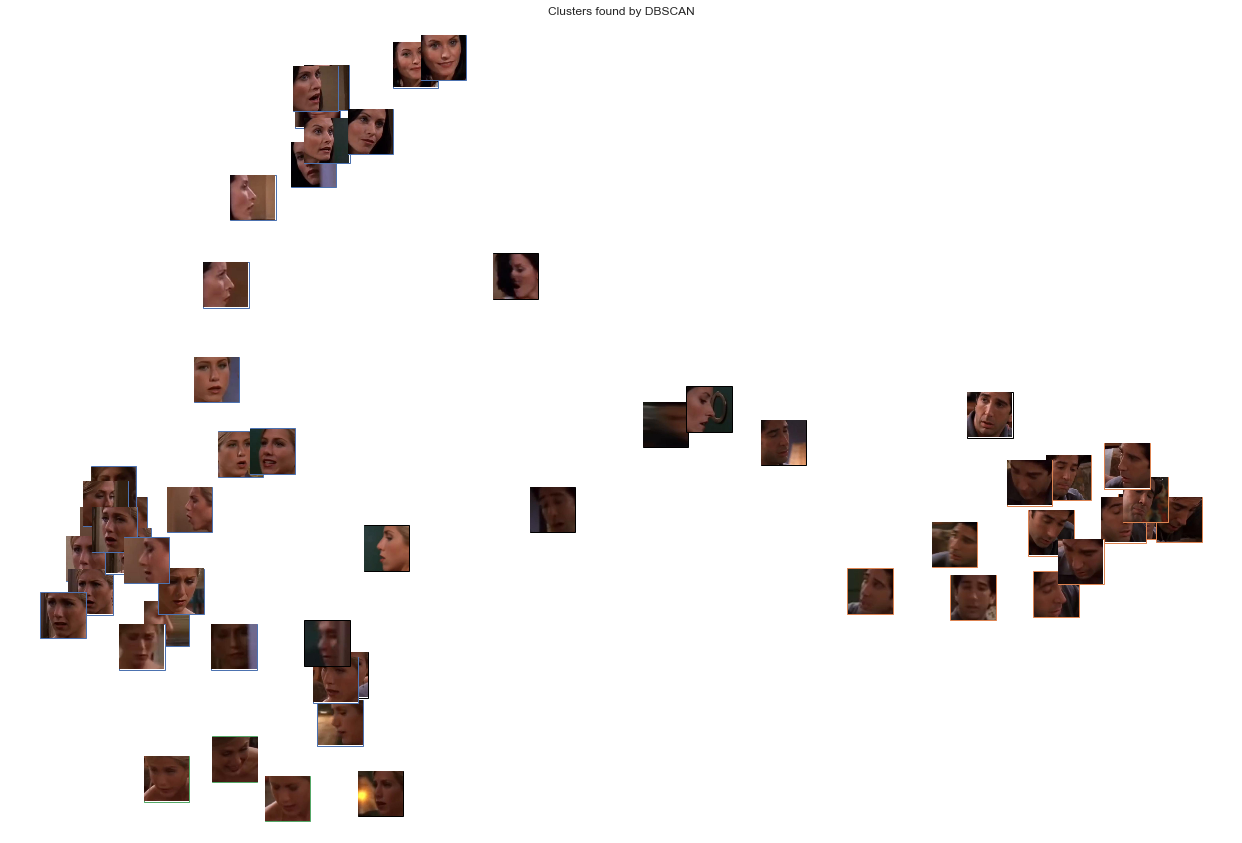

In [37]:
clusters_hdbscan = plot_clusters(embedded_track_features, tracks_images, hdbscan.HDBSCAN, alpha=1.0, min_cluster_size=MIN_TRACKS_FOR_IDENTITY, min_samples=1)
clusters_agglomerative = plot_clusters(embedded_track_features, tracks_images, cluster.AgglomerativeClustering, n_clusters=NUM_CLUSTERS, linkage='ward')
clusters_dbscan = plot_clusters(embedded_track_features, tracks_images, cluster.DBSCAN, n_jobs=-1, eps=0.5, min_samples=MIN_TRACKS_FOR_IDENTITY)

In [38]:
# clusters and the number of images on each one of them
ids, counts = np.unique(clusters_hdbscan, return_counts=True)
labels_dict = get_labels_dict(clusters_hdbscan, labels)
print('clusters_hdbscan:', labels_dict, ids, counts)

ids, counts = np.unique(clusters_agglomerative, return_counts=True)
labels_dict = get_labels_dict(clusters_agglomerative, labels)
print('clusters_agglomerative:', labels_dict, ids, counts)

ids, counts = np.unique(clusters_dbscan, return_counts=True)
labels_dict = get_labels_dict(clusters_dbscan, labels)
print('clusters_dbscan:', labels_dict, ids, counts)

clusters_hdbscan: {'Rachel': [3, 3, 3, 3, 3, 3, 2, -1, -1, 3, 3, 3, 2, 2, -1, 3, -1, 3, 3, 3, -1, 3, 3, 3, 3, 3, 3], 'Ross': [1, 1, 1, -1, 1, -1, 1, 0, -1, -1, 1, 0, 1, 0, 0, -1, 0], 'Monica': [-1, 6, 6, 5, 4, 5, 5, 4, 5, 5, -1, -1]} [-1  0  1  2  3  4  5  6] [13  5  7  3 19  2  5  2]
clusters_agglomerative: {'Rachel': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Ross': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Monica': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]} [0 1 2] [18 27 11]
clusters_dbscan: {'Rachel': [0, 0, 0, 0, 0, 0, 2, 0, -1, 0, 0, 0, 2, 2, -1, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0], 'Ross': [1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1], 'Monica': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1]} [-1  0  1  2] [10 30 13  3]


In [39]:
scores = {}
scores['dbscan'] = get_clusters_scores(labels, clusters_dbscan, track_ids)
scores['hdbscan'] = get_clusters_scores(labels, clusters_hdbscan, track_ids)
scores['hac'] = get_clusters_scores(labels, clusters_agglomerative, track_ids, noFalseCluster=True)
scores['original_dbscan'] = get_clusters_scores(labels, original_clusters_dbscan, track_ids)
scores['original_hdbscan'] = get_clusters_scores(labels, original_clusters_hdbscan, track_ids)
scores['original_hac'] = get_clusters_scores(labels, original_clusters_agglomerative, track_ids, noFalseCluster=True)


def highlight_max(x):
    return np.where(x == np.nanmax(x.to_numpy()), "font-weight: bold;", '')

import pandas as pd
df = pd.DataFrame.from_dict(scores)

df.to_csv(f'{output_directory}/{embedding_name}.csv')


styled_df = df.style.apply(highlight_max, axis=1)
styled_df

,dbscan,hdbscan,hac,original_dbscan,original_hdbscan,original_hac
precision,0.647619,0.848901,0.966270,0.381181,0.680060,0.513821
recall,0.630174,0.427735,0.967262,0.872471,0.267565,0.516671
fscore,0.638778,0.568846,0.966766,0.530561,0.384035,0.515242
homogeneity,0.492809,0.761258,0.933924,0.015789,0.501097,0.299518
completeness,0.452056,0.443407,0.940684,0.064041,0.251284,0.286855
rand_score,0.703896,0.761039,0.981818,0.413636,0.594156,0.637013
accuracy,nan,nan,0.982143,nan,nan,0.625000


In [40]:
from evaluate_training import plot_dendogram, calculate_tracks_similarity, draw_histogram

C:\Users\noiba\anaconda3\envs\test\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


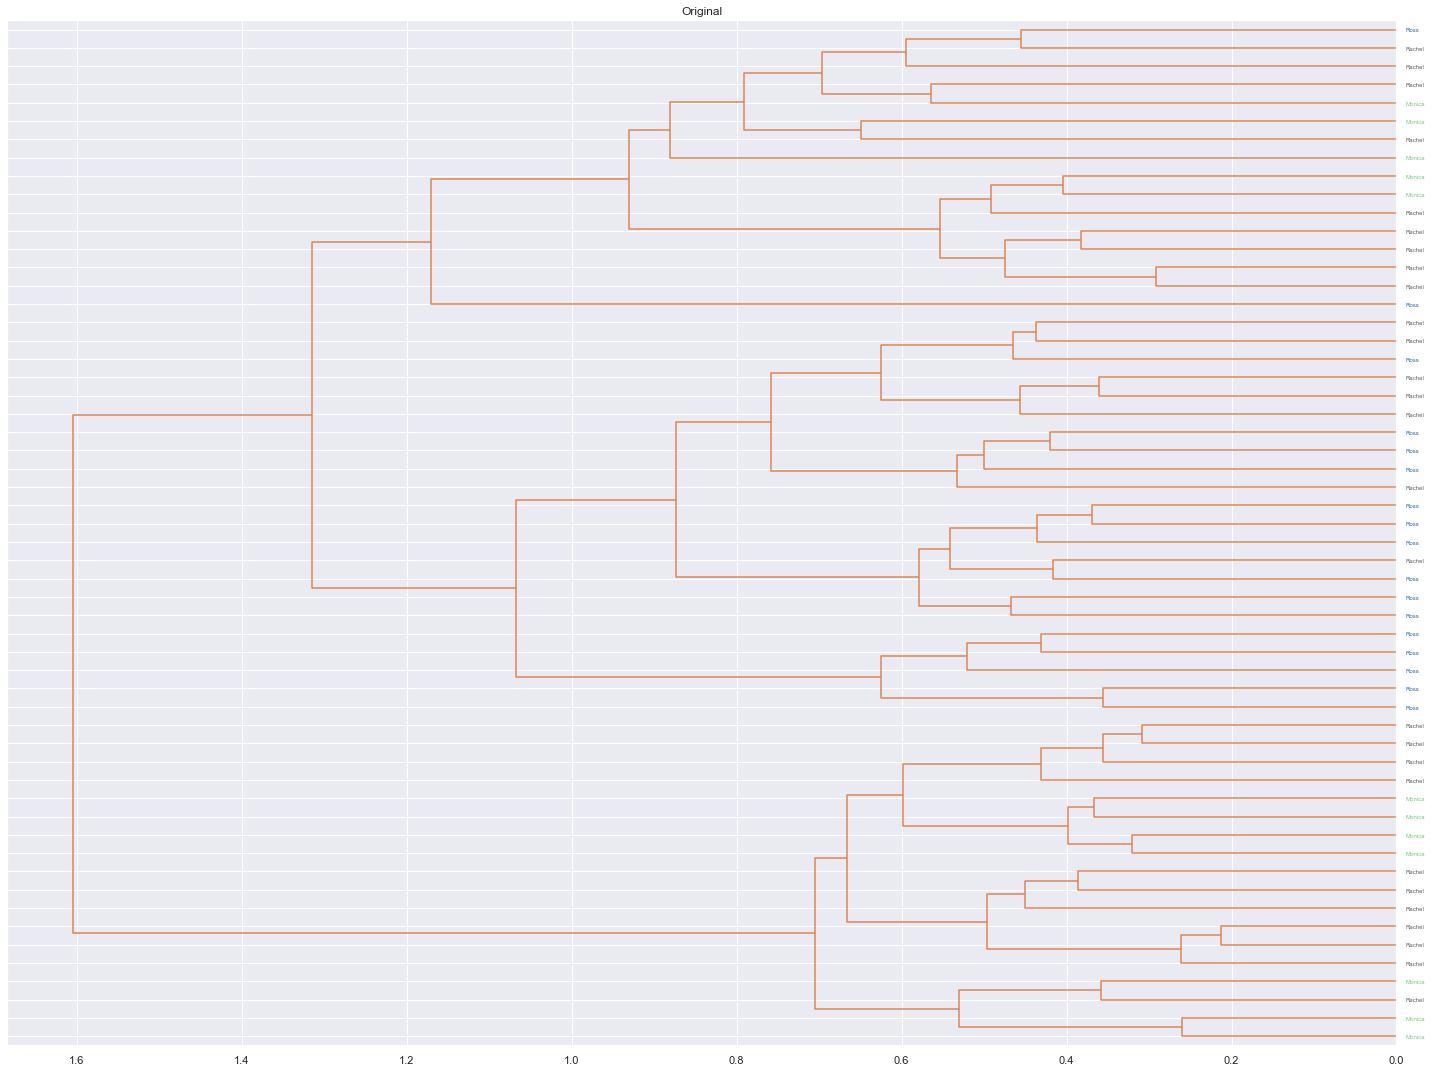

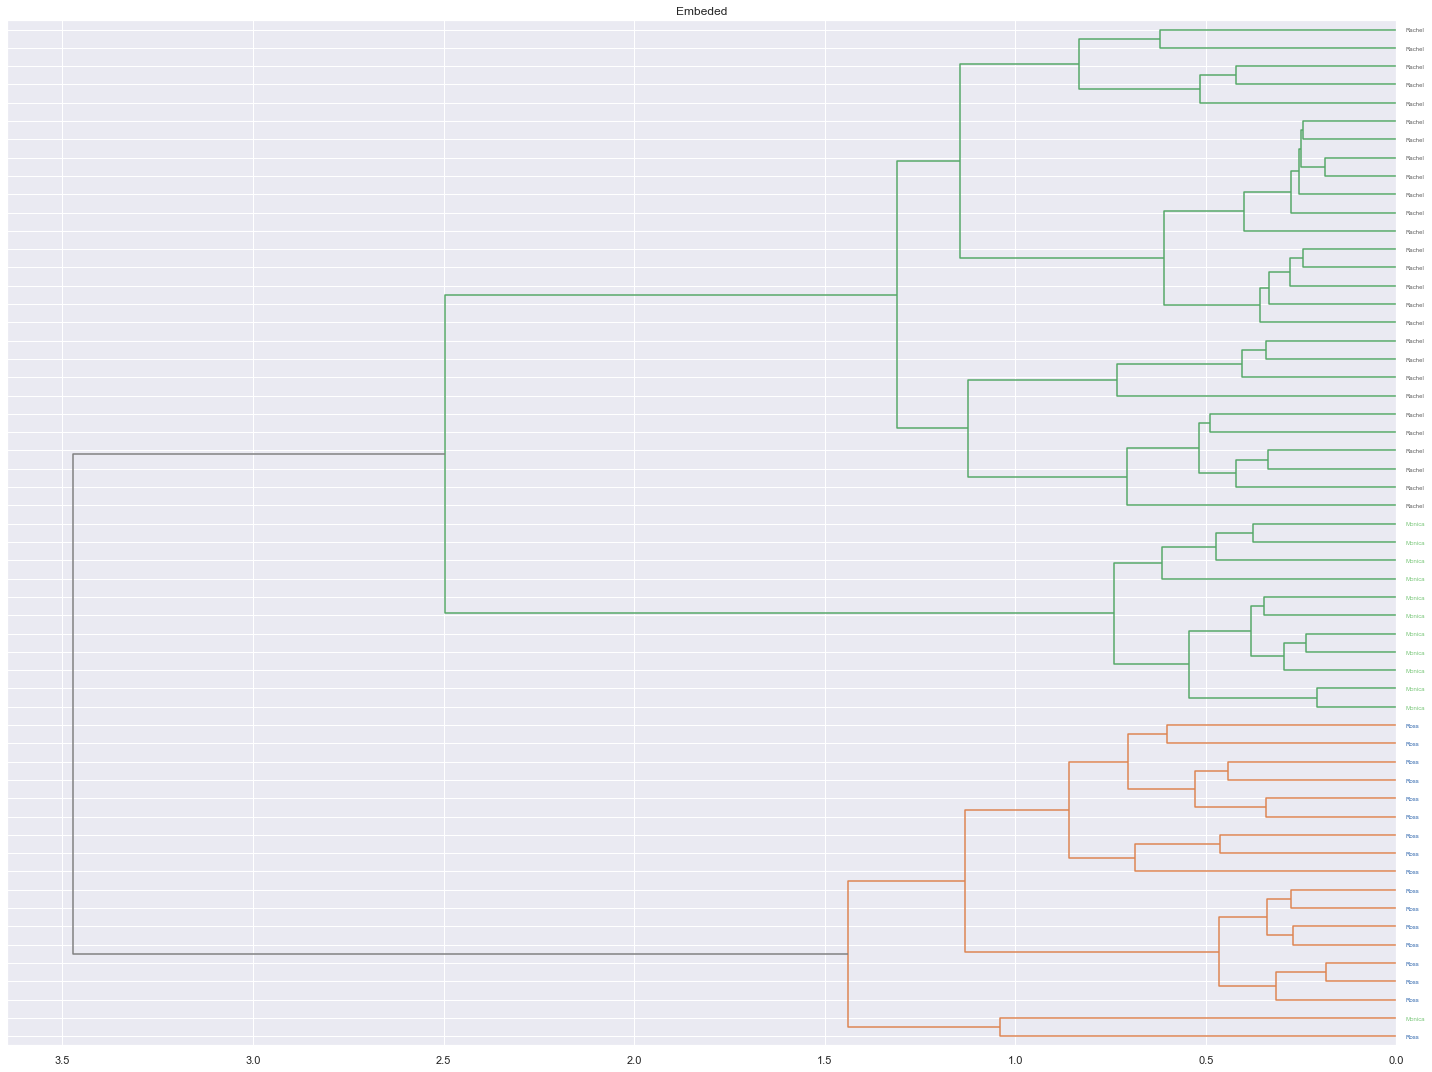

In [41]:
plot_dendogram(original_track_features, labels, 'Original', embedding_name, output_directory)
plot_dendogram(embedded_track_features, labels, 'Embeded', embedding_name, output_directory)